Dataset split into train, validation, and test sets.
Found 1050 images belonging to 2 classes.
Found 225 images belonging to 2 classes.
Found 225 images belonging to 2 classes.
Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 453ms/step - accuracy: 0.6686 - loss: 3.8187 - val_accuracy: 0.8533 - val_loss: 0.4308
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.7594 - loss: 0.5215 - val_accuracy: 0.8667 - val_loss: 0.4124
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.7938 - loss: 0.4470 - val_accuracy: 0.8711 - val_loss: 0.3627
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.7816 - loss: 0.4608 - val_accuracy: 0.8667 - val_loss: 0.3954
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7558 - loss: 0.4498 - val_accuracy: 0.8622 - val_loss: 0.3789
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.7134 - loss: 0.4791 - val_accuracy: 0.8622 - val_loss: 0.4046
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/s

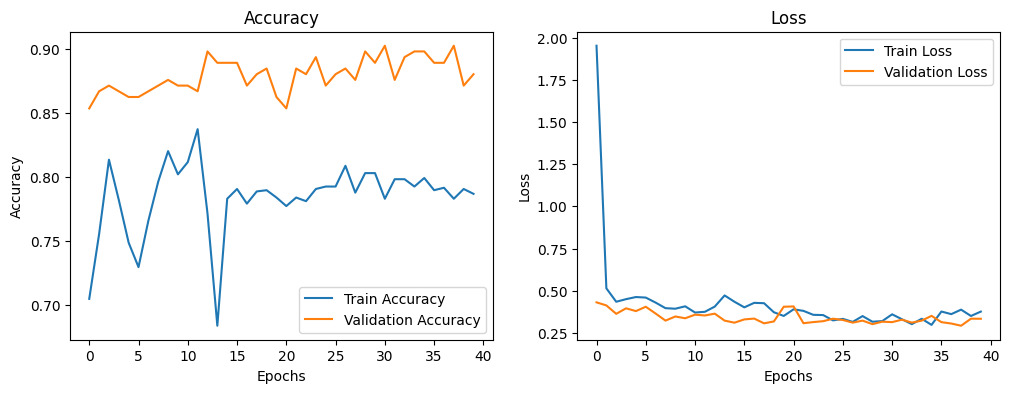

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 703ms/step
Confusion Matrix:
[[ 48  27]
 [  0 150]]
Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.64      0.78        75
      normal       0.85      1.00      0.92       150

    accuracy                           0.88       225
   macro avg       0.92      0.82      0.85       225
weighted avg       0.90      0.88      0.87       225



In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

original_dataset_dir = "/content/drive/MyDrive/000/covid_19/COVID-19/selected"
base_dir = "/content"

os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

classes = ["covid", "normal"]
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)
    files = os.listdir(class_dir)

    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)

    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for file in train_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(train_dir, class_name, file)
        shutil.copyfile(src, dst)

    for file in val_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(val_dir, class_name, file)
        shutil.copyfile(src, dst)

    for file in test_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(test_dir, class_name, file)
        shutil.copyfile(src, dst)

print("Dataset split into train, validation, and test sets.")

train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=out)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator
)

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred_classes, target_names=classes)
print("Classification Report:")
print(report)


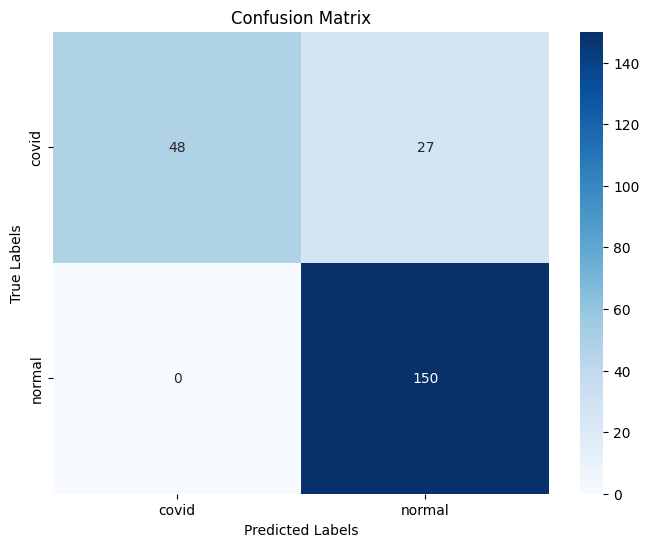

Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.64      0.78        75
      normal       0.85      1.00      0.92       150

    accuracy                           0.88       225
   macro avg       0.92      0.82      0.85       225
weighted avg       0.90      0.88      0.87       225



In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=classes)
print("Classification Report:")
print(report)
